In [2]:


import os
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_xla
import torch_xla.core.xla_model as xm

import numpy as np
import pandas as pd
import umap
import csv

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors

from scipy.spatial.distance import pdist, squareform, mahalanobis
from scipy.special import softmax
from numpy.linalg import inv

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm

from timm import create_model
import torch_xla.core.xla_model as xm
device = xm.xla_device()
print(f"TPU Device: {device}")
import logging
logging.getLogger().setLevel(logging.ERROR)
os.environ['TPU_LOG_LEVEL'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['XLA_FLAGS'] = '--xla_hlo_profile=false'



TPU Device: xla:0


In [3]:
home_dir = '/content/drive/MyDrive'
dataset_path = os.path.join(home_dir, 'tomato_augmented')
model_path = os.path.join(home_dir, 'tomato-manifold/tomato_efficientnet_b0_finetuned.pth')

val_path = os.path.join(dataset_path)

print(f"Val dset path: {val_path}")
print(f"Model path: {model_path}")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Val dset path: /content/drive/MyDrive/tomato_augmented
Model path: /content/drive/MyDrive/tomato-manifold/tomato_efficientnet_b0_finetuned.pth


In [4]:
val_dataset = ImageFolder(root=val_path, transform=preprocess)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = [
    'Tomato_Late_blight', 'Tomato_healthy', 'Tomato_Early_blight',
    'Tomato_Septoria_leaf_spot', 'Tomato_Tomato_yellow_Leaf_Curl_Virus',
    'Tomato_Bacterial_spot', 'Tomato_Target_Spot', 'Tomato_Tomato_mosaic_virus',
    'Tomato_Leaf_Mold', 'Tomato_Spider_mites Two-spotted_spider_mite'
]

dataset_classes = val_dataset.classes


In [5]:
device = xm.xla_device()

model = models.efficientnet_b0(weights=None)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class_names = [
    'Tomato_Late_blight',
    'Tomato_healthy',
    'Tomato_Early_blight',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Tomato_yellow_Leaf_Curl_Virus',
    'Tomato_Bacterial_spot',
    'Tomato_Target_Spot',
    'Tomato_Tomato_mosaic_virus',
    'Tomato_Leaf_Mold',
    'Tomato_Spider_mites Two-spotted_spider_mite'
]

def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        probs = torch.softmax(output, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
        pred_label = class_names[pred_idx]
        confidence = probs[pred_idx].item()
    return pred_label, confidence

def extract_class_from_filename(fname):
    for cname in class_names:
        if fname.startswith(cname):
            return cname
    return "Unknown"

aug_path = "/content/drive/MyDrive/tomato_augmented"
csv_file = "predictions_augmented.csv"

with open(csv_file, mode="w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["image_path", "true_label", "predicted_label", "confidence"])

    for root, dirs, files in os.walk(aug_path):
        for img_name in files:
            img_path = os.path.join(root, img_name)
            try:
                true_label = os.path.basename(root)
                pred_label, conf = predict_image(img_path)
                writer.writerow([img_path, true_label, pred_label, f"{conf:.4f}"])
            except Exception as e:
                print(f"Error: {img_path} {e}")


In [6]:
df = pd.read_csv("predictions_augmented.csv")
df = df[df["true_label"] != ".ipynb_checkpoints"].reset_index(drop=True)

In [7]:
def normalize(label):
    label = label.replace("___", "_")
    label = label.replace("Yellow", "yellow")
    return label

df["normalized_true"] = df["true_label"].apply(normalize)

df["correct"] = df["normalized_true"] == df["predicted_label"]

accuracy = df["correct"].mean() * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 85.18%


In [8]:


print('confidence stats')
df.confidence.describe()



confidence stats


count    5000.000000
mean        0.752610
std         0.213796
min         0.178500
25%         0.600475
50%         0.835300
75%         0.929500
max         0.998100
Name: confidence, dtype: float64

In [9]:


filtered = df[(df["confidence"] >= 0) & (df["confidence"] <= .5)]

accuracy = filtered["correct"].mean() * 100
print(f"Uncertain range (0%–50%) accuracy: {accuracy:.2f}%")
print(f"Number of images: {len(filtered)}")



Uncertain range (0%–50%) accuracy: 45.29%
Number of images: 892


In [10]:
image_paths = df["image_path"].tolist()

def extract_features(img_path, model, transform, device):
    img = Image.open(img_path).convert("RGB")
    tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feats = model.features(tensor)
        pooled = F.adaptive_avg_pool2d(feats, (1,1))
        vec = pooled.view(pooled.size(0), -1).cpu().numpy()
    return vec[0]

features = []
for path in image_paths:
    try:
        vec = extract_features(path, model, transform, device)
        features.append(vec)
    except Exception as e:
        print(f"Hata: {path} -> {e}")

features = np.array(features)
np.save("augmented_features.npy", features)


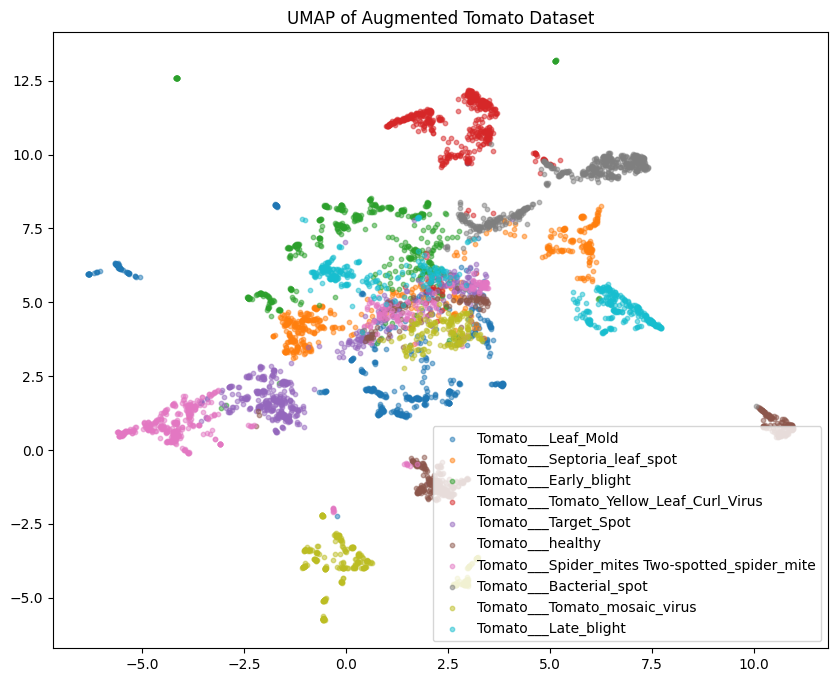

In [11]:
import umap
import umap.umap_ as umap
features = np.load("augmented_features.npy")
labels = df["true_label"].tolist()

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine",random_state=42)
embedding = reducer.fit_transform(features)

plt.figure(figsize=(10, 8))
for label in set(labels):
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=label, alpha=0.5, s=10)
plt.legend()
plt.title("UMAP of Augmented Tomato Dataset")
plt.show()


Text(0.5, 1.0, 'UMAP with Confidence Coloring')

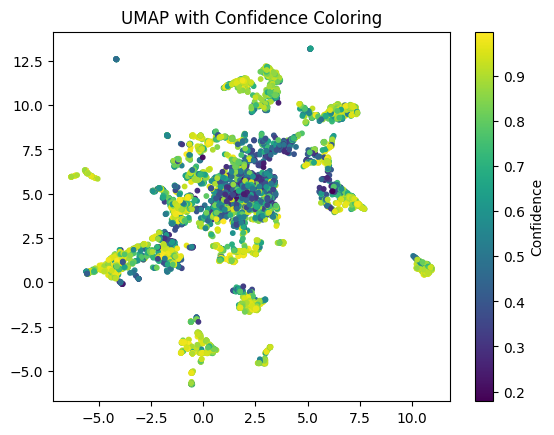

In [12]:
colors = df["confidence"].values
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap="viridis", s=10)
plt.colorbar(label="Confidence")
plt.title("UMAP with Confidence Coloring")

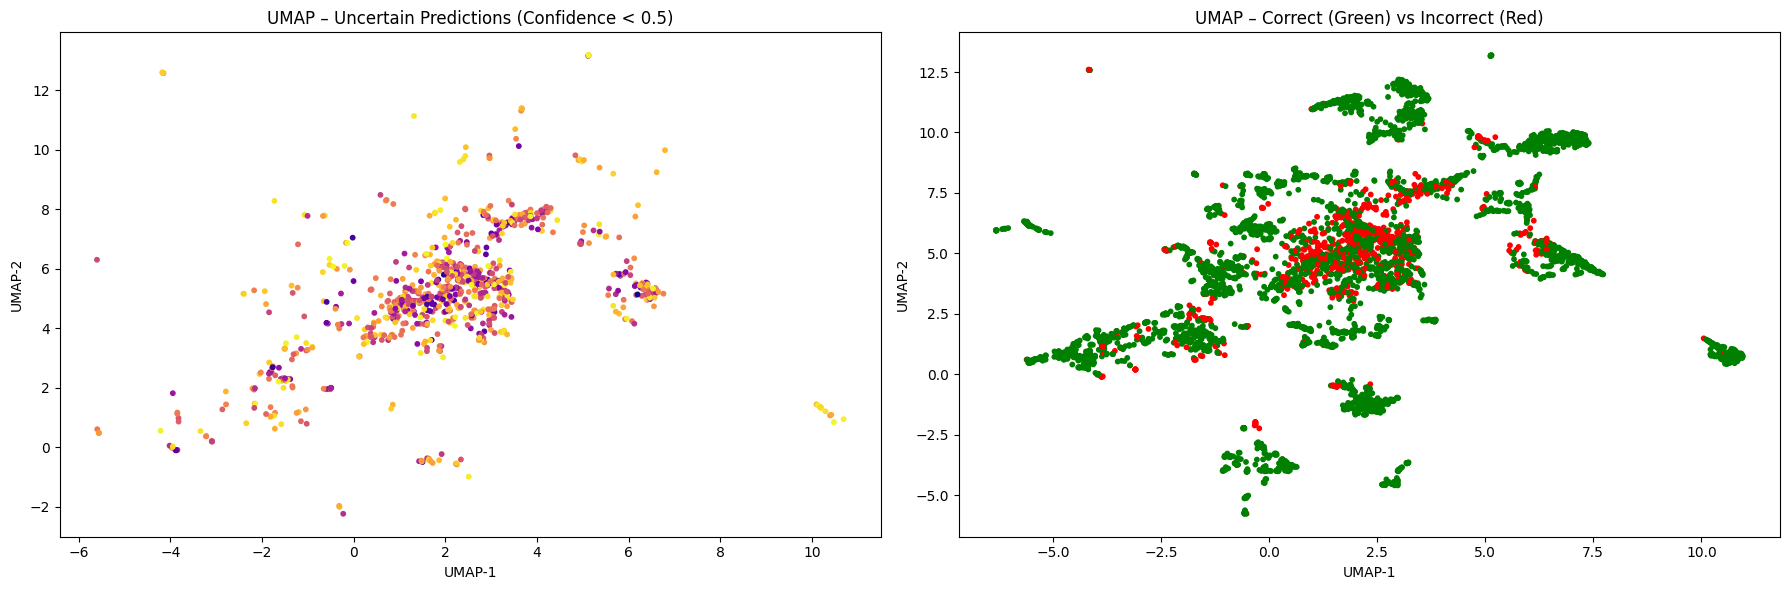

In [13]:
df = df[df["true_label"] != ".ipynb_checkpoints"]
df_uncertain = df[df["confidence"] < 0.5]


thresholds = np.linspace(0.0, 1.0, 50)
coverage = []
accuracy = []

for t in thresholds:
    subset = df[df["confidence"] >= t]
    if len(subset) > 0:
        acc = (subset["true_label"] == subset["predicted_label"]).mean()
        coverage.append(len(subset) / len(df))
        accuracy.append(acc)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

idx_uncertain = df_uncertain.index
axs[0].scatter(embedding[idx_uncertain, 0], embedding[idx_uncertain, 1],
               c=df_uncertain["confidence"], cmap="plasma", s=10)
axs[0].set_title("UMAP – Uncertain Predictions (Confidence < 0.5)")
axs[0].set_xlabel("UMAP-1")
axs[0].set_ylabel("UMAP-2")

colors = df["correct"].map({True: "green", False: "red"})
axs[1].scatter(embedding[:, 0], embedding[:, 1], c=colors, s=10)
axs[1].set_title("UMAP – Correct (Green) vs Incorrect (Red)")
axs[1].set_xlabel("UMAP-1")
axs[1].set_ylabel("UMAP-2")



plt.tight_layout()
plt.show()


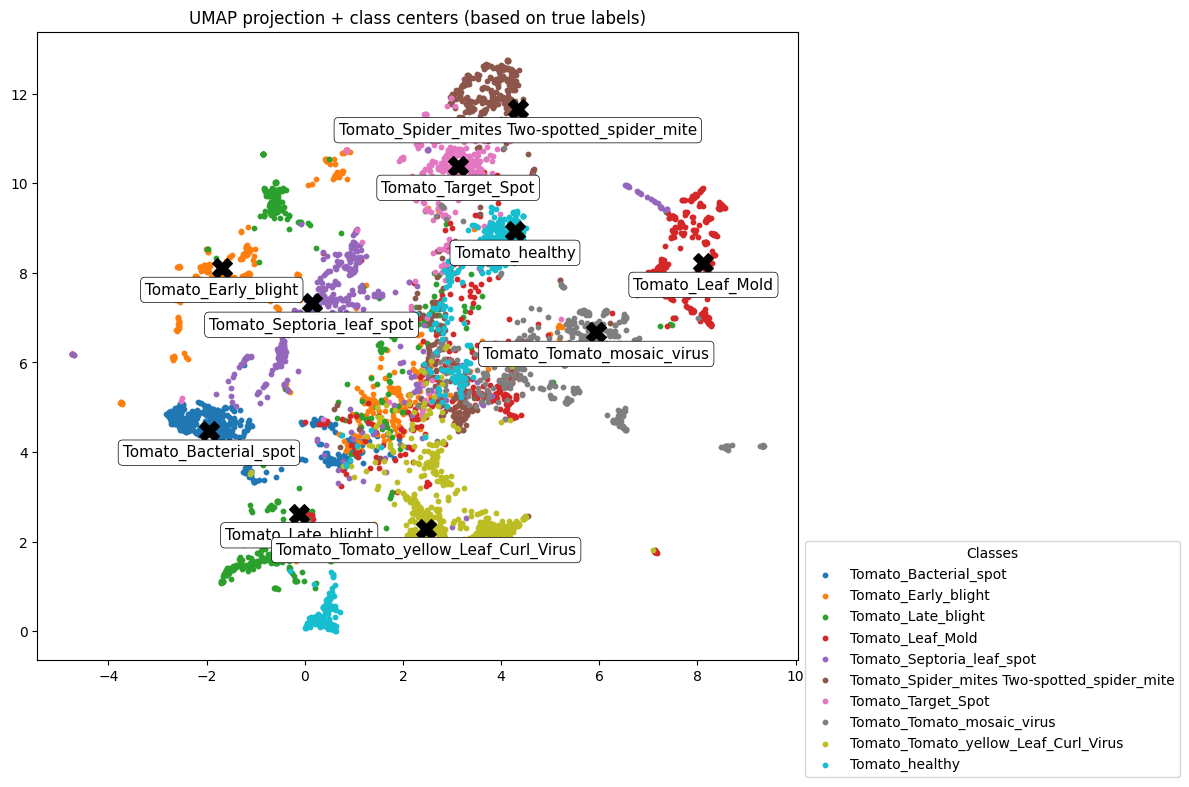

In [14]:
classes = np.unique(df.normalized_true)
class_to_idx = {cls: i for i, cls in enumerate(classes)}
idx_to_class = {i: cls for cls, i in class_to_idx.items()}

pred_str = df.predicted_label.values
y_hat = np.array([class_to_idx[p] for p in pred_str])
y_hat_str = np.array([idx_to_class[i] for i in y_hat])

centers_dict = {}
true_str = df.normalized_true.values
for c in classes:
    Xc = features[true_str == c]
    if len(Xc) == 0:
        continue
    center = Xc.mean(axis=0)
    centers_dict[c] = center

center_labels = list(centers_dict.keys())
center_vectors = np.vstack(list(centers_dict.values()))

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
X_umap = umap_model.fit_transform(features)
centers_umap = umap_model.transform(center_vectors)

palette = sns.color_palette("tab10", n_colors=len(classes))
color_map = {cls: palette[i] for i, cls in enumerate(classes)}

plt.figure(figsize=(12, 8))
for c in classes:
    plt.scatter(X_umap[y_hat_str == c, 0], X_umap[y_hat_str == c, 1],
                s=10, label=c, color=color_map[c])

for i, label in enumerate(center_labels):
    x, y = centers_umap[i]
    plt.scatter(x, y, s=200, c='black', marker='X')
    plt.text(x, y - 0.3, label, fontsize=11, ha='center', va='top',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

plt.legend(loc='upper left', bbox_to_anchor=(1, 0.2), fontsize=10, title="Classes")
plt.title("UMAP projection + class centers (based on true labels)")
plt.subplots_adjust(right=0.75)
plt.tight_layout()
plt.show()

<Axes: >

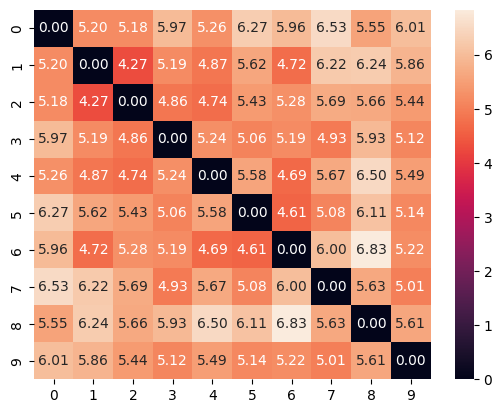

In [15]:
dist_matrix = squareform(pdist(center_vectors, metric='euclidean'))
sns.heatmap(data=dist_matrix,fmt='.2f',annot=True)

In [16]:
import torch_xla
import torch_xla.core.xla_model as xm
from torch.utils.data import DataLoader

device = xm.xla_device()

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(img)

dataset = ImageDataset(image_paths, transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

model = model.to(device)
model.eval()

logits_list = []
with torch.no_grad():
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        logits_list.append(out.cpu().numpy())

import numpy as np
logits = np.concatenate(logits_list, axis=0)


In [18]:
probs = softmax(logits, axis=1)
confidences = np.max(probs, axis=1)
uncertainty_score = 1 - confidences

In [19]:
k = 5
nn = NearestNeighbors(n_neighbors=k+1, metric='euclidean')
nn.fit(features)
distances, _ = nn.kneighbors(features)
density_score = distances[:, 1:].mean(axis=1)


In [20]:
outlier_score = np.zeros(len(features))
labels = df.normalized_true.values
for cls in np.unique(labels):
    Xc = features[labels == cls]
    Xc = np.array(Xc)
    mean_vec = Xc.mean(axis=0)
    cov = np.cov(Xc, rowvar=False)
    cov += np.eye(cov.shape[0]) * 1e-6
    cov_inv = inv(cov)

    idxs = np.where(labels == cls)[0]
    for i in idxs:
        outlier_score[i] = mahalanobis(features[i], mean_vec, cov_inv)


In [21]:
outlier_score = np.zeros(len(features))
labels = df.normalized_true.values

for cls in np.unique(labels):
    class_mask = (labels == cls)
    Xc = features[class_mask]

    mean_vec = Xc.mean(axis=0)
    cov = np.cov(Xc, rowvar=False)
    cov += np.eye(cov.shape[0]) * 1e-6
    cov_inv = inv(cov)
    diff = Xc - mean_vec

    mahalanobis_dist_sq = np.sum(diff @ cov_inv * diff, axis=1)
    mahalanobis_dist = np.sqrt(mahalanobis_dist_sq)

    outlier_score[class_mask] = mahalanobis_dist


In [22]:
assert uncertainty_score.shape[0] == 5000
assert density_score.shape[0] == 5000
assert outlier_score.shape[0] == 5000

scores = np.vstack([
    uncertainty_score.reshape(-1),
    density_score.reshape(-1),
    outlier_score.reshape(-1)
]).T

scaler = MinMaxScaler()
scores_norm = scaler.fit_transform(scores)

weights = np.array([1.0, 1.0, 1.0])
void_score = scores_norm @ weights

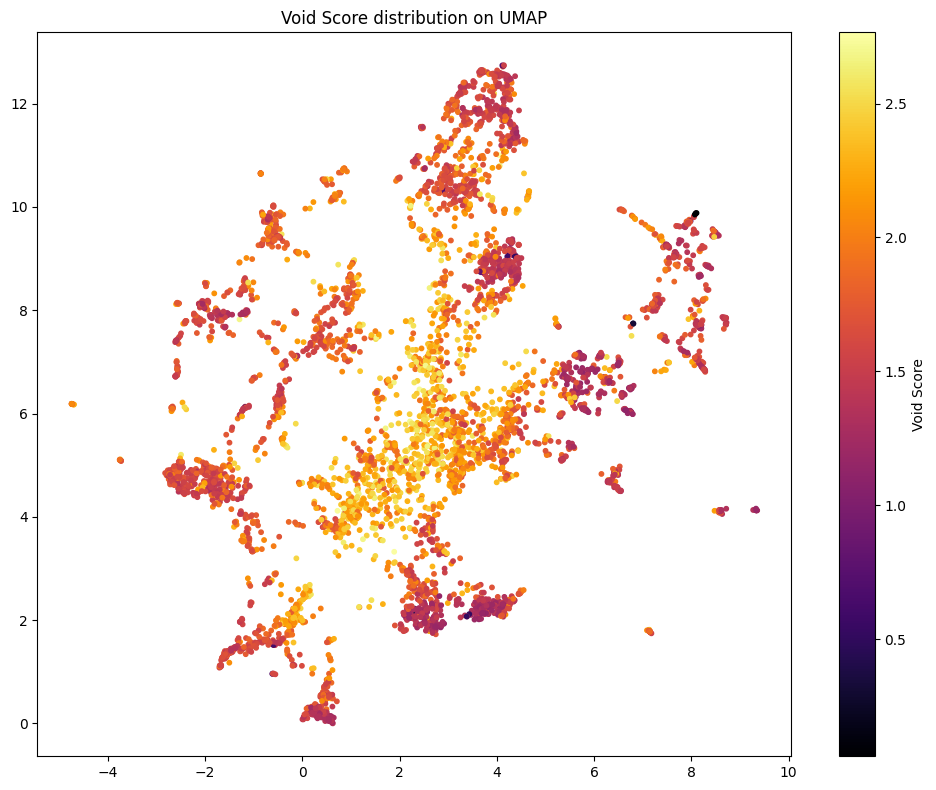

In [23]:
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=void_score, cmap='inferno', s=10)
plt.colorbar(label='Void Score')
plt.title("Void Score distribution on UMAP")
plt.tight_layout()
plt.show()


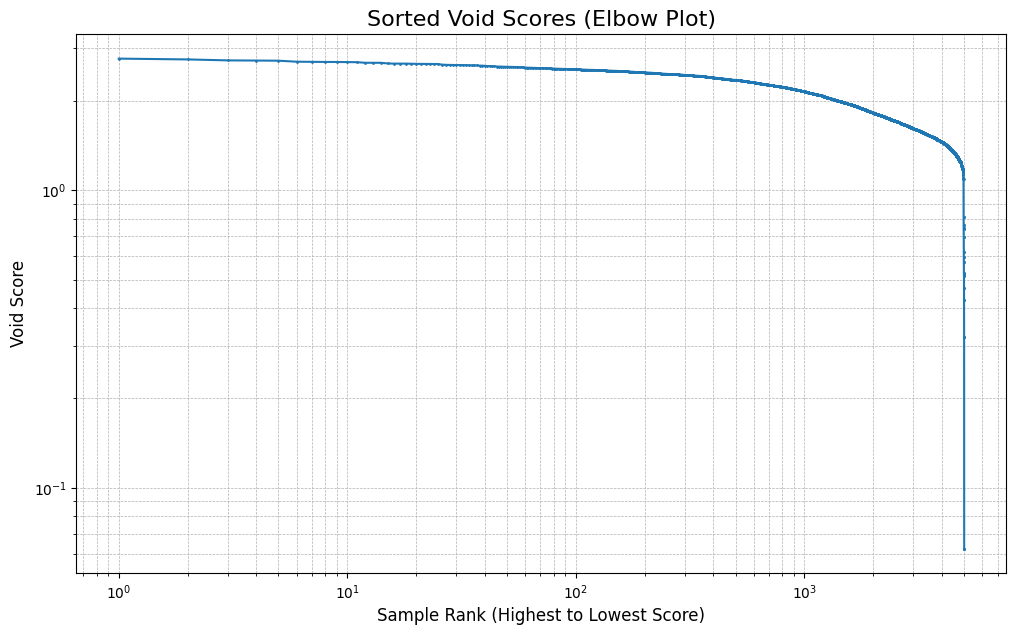

In [24]:
sorted_scores = np.sort(void_score)[::-1]

sample_rank = np.arange(1, len(sorted_scores) + 1)

plt.figure(figsize=(12, 7))
plt.plot(sample_rank, sorted_scores, marker='.', linestyle='-', markersize=2)

plt.title('Sorted Void Scores (Elbow Plot)', fontsize=16)
plt.xlabel('Sample Rank (Highest to Lowest Score)', fontsize=12)
plt.ylabel('Void Score', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xscale('log')
plt.yscale('log')

plt.show()

In [25]:
df['void_score'] = void_score
df_sorted = df.sort_values(by='void_score', ascending=False)
print(df_sorted[[ 'correct','void_score', 'confidence']].head(20))

      correct  void_score  confidence
1110    False    2.766223      0.2099
263     False    2.749075      0.3076
3139    False    2.728804      0.2153
1296    False    2.725575      0.2440
29      False    2.722078      0.2980
3190    False    2.701131      0.3240
3372    False    2.697828      0.2845
1246    False    2.695778      0.2655
2369    False    2.695070      0.2105
1163    False    2.691768      0.2321
175     False    2.690782      0.2576
125     False    2.678700      0.2796
3267    False    2.678453      0.3236
3475    False    2.678275      0.2657
1446    False    2.664883      0.2695
1011    False    2.661557      0.2466
1182     True    2.661271      0.2969
919     False    2.661192      0.2912
2204    False    2.657845      0.2094
1189    False    2.656637      0.2020


In [26]:
top_9_void = df_sorted.head(9)
bottom_9_void = df_sorted.tail(9).sort_values(by='void_score', ascending=True)

def plot_image_grid(df_subset, title, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.suptitle(title, fontsize=16, y=1.02)
    axes = axes.flatten()

    for i, (idx, row) in enumerate(df_subset.iterrows()):
        if i >= rows * cols:
            break

        ax = axes[i]
        img = Image.open(row['image_path']).convert('RGB')
        ax.imshow(img)
        ax.set_title(
            f"Void: {row['void_score']:.2f}\n"
            f"Conf: {row['confidence']:.2f}\n"
            f"Label: {row['true_label']}", fontsize=8
        )
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

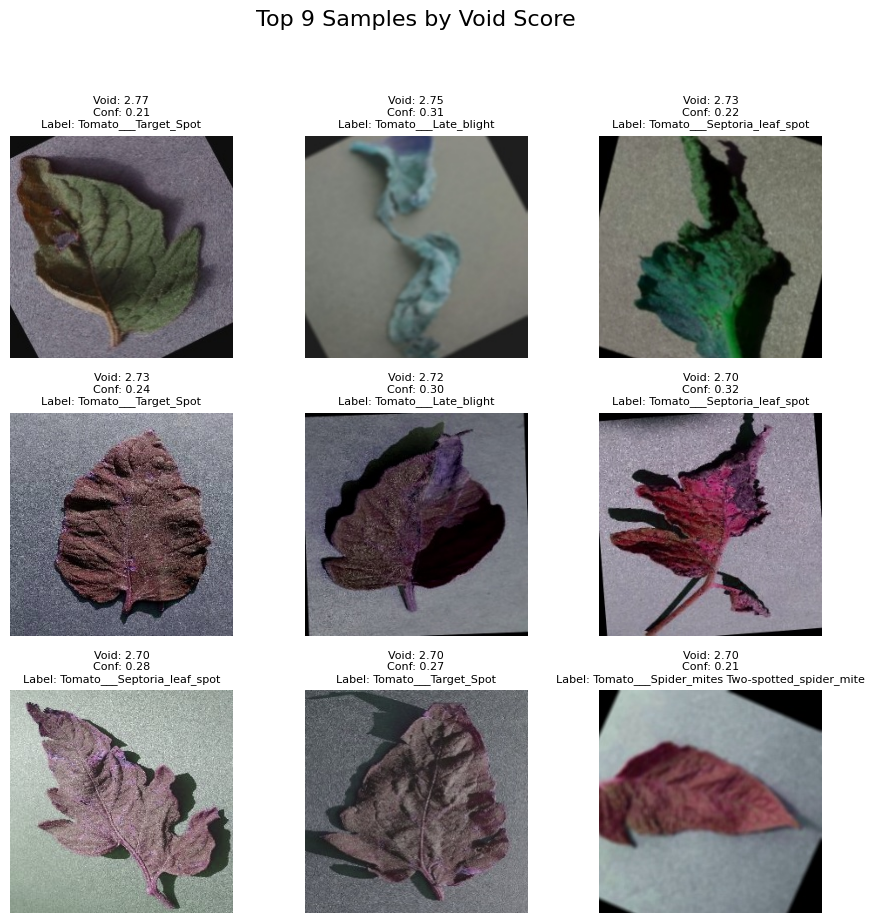

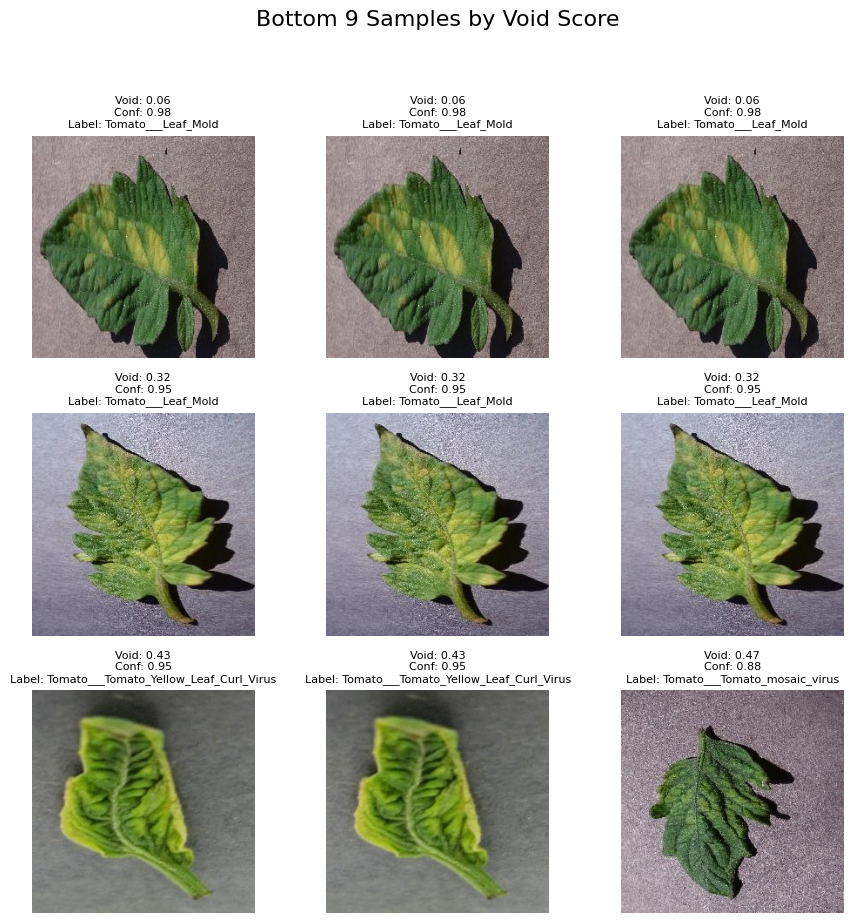

In [27]:
plot_image_grid(top_9_void, "Top 9 Samples by Void Score")
plot_image_grid(bottom_9_void, "Bottom 9 Samples by Void Score")

In [28]:
thresold = 1.8
df_high_void = df[df['void_score'] >= thresold]


In [29]:
print('value counts of correct')
print(df_high_void.correct.value_counts())
print('------***--------')
print('stats of confidence')
print(df_high_void.confidence.describe)



value counts of correct
correct
True     1376
False     695
Name: count, dtype: int64
------***--------
stats of confidence
<bound method NDFrame.describe of 0       0.3240
1       0.7972
2       0.8382
4       0.3617
7       0.9511
         ...  
4942    0.5800
4963    0.6894
4976    0.6429
4979    0.7664
4993    0.7716
Name: confidence, Length: 2071, dtype: float64>


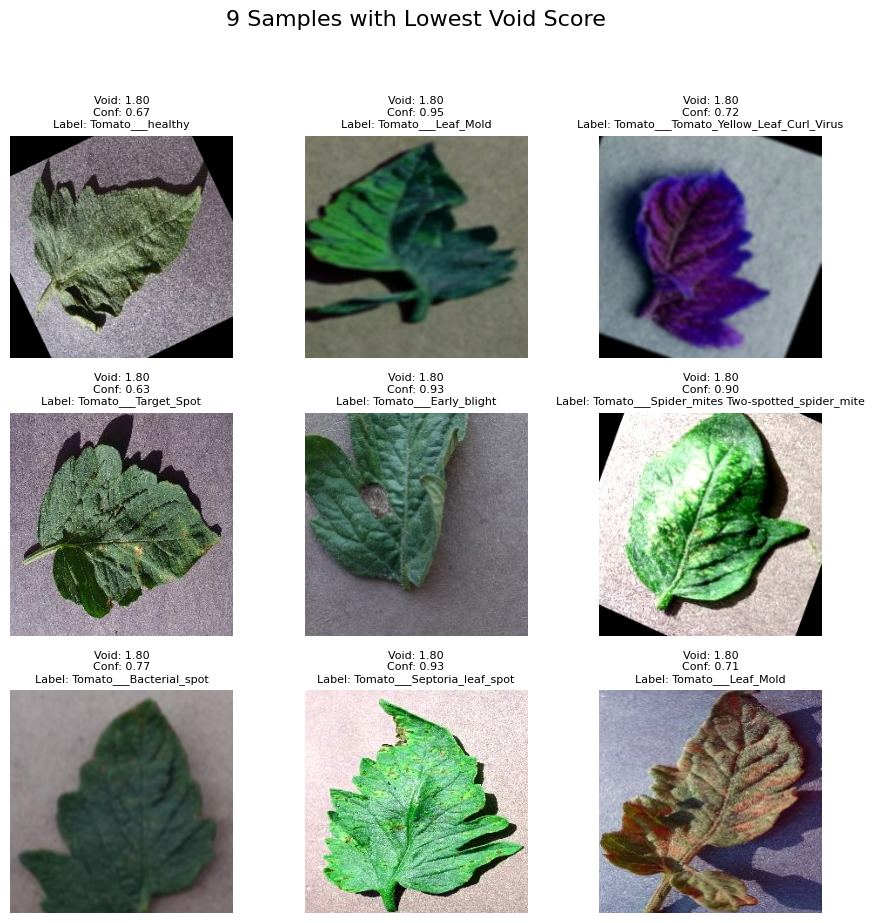

2884     True
4090     True
4614     True
1364    False
958      True
2344     True
1905     True
3465     True
4270     True
Name: correct, dtype: bool


In [30]:
plot_this = df_high_void.sort_values(by='void_score', ascending=True)

plot_this = plot_this.head(9)

plot_image_grid(plot_this, "9 Samples with Lowest Void Score")
print(plot_this.correct)



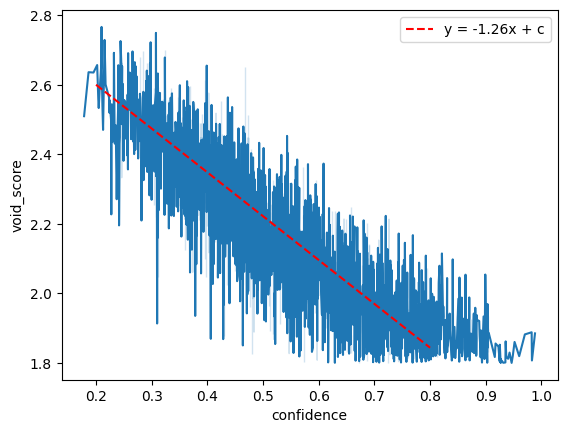

In [31]:
sns.lineplot(data=df_high_void, x='confidence', y='void_score')
plt.xlabel('confidence')
plt.ylabel('void_score')

x_start, y_start = 0.2, 2.6
slope = -1.26

x_vals = np.linspace(0.2, .8, 100)
y_vals = y_start + slope * (x_vals - x_start)

plt.plot(x_vals, y_vals, color='red', linestyle='--', label='y = -1.26x + c')
plt.legend()
plt.show()

In [32]:
X = df_high_void[['confidence', 'correct']].astype(float)
X = sm.add_constant(X)

y = df_high_void['void_score']


model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             void_score   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     2931.
Date:                Fri, 03 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:50:53   Log-Likelihood:                 1488.6
No. Observations:                2071   AIC:                            -2971.
Df Residuals:                    2068   BIC:                            -2954.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7696      0.008    326.749      0.0

In [33]:
X = df_high_void[['confidence','correct']].astype(float)
y = df_high_void['void_score']

model = sm.OLS(y, X).fit()
print(model.params)


confidence    3.436873
correct       0.006575
dtype: float64


In [34]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import numpy as np

X = df_high_void[['confidence', 'correct']].astype(float)
X = sm.add_constant(X)
y = df_high_void['void_score']

model = sm.OLS(y, X).fit()
y_pred = model.predict(X)

mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)


MAE: 0.09374254740021262
MAPE: 0.04406918505408099
RMSE: 0.11792284319597111


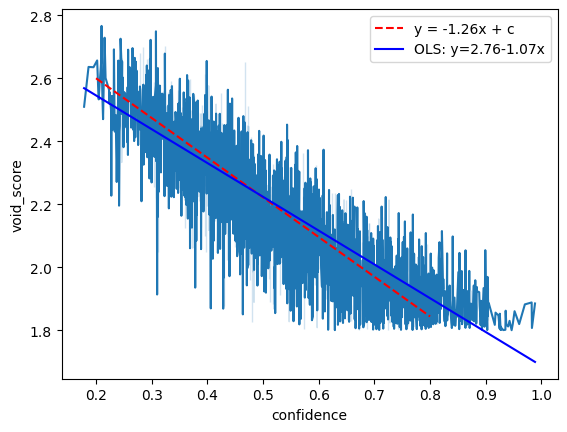

In [35]:
sns.lineplot(data=df_high_void, x='confidence', y='void_score')
plt.xlabel('confidence')
plt.ylabel('void_score')


x_start, y_start = 0.2, 2.6
slope = -1.26
x_vals = np.linspace(0.2, 0.8, 100)
y_vals = y_start + slope * (x_vals - x_start)
plt.plot(x_vals, y_vals, color='red', linestyle='--', label='y = -1.26x + c')

x_vals_reg = np.linspace(df_high_void['confidence'].min(),
                         df_high_void['confidence'].max(), 100)
y_vals_reg = 2.7601 - 1.0728 * x_vals_reg
plt.plot(x_vals_reg, y_vals_reg, color='blue', linestyle='-', label='OLS: y=2.76-1.07x')

plt.legend()
plt.show()


In [36]:
threshold = 1.8

df_high_void = df_high_void[df_high_void['void_score'] >= threshold]

X = df[['confidence','correct']].astype(float)
X = sm.add_constant(X)
y_pred = model.predict(X)
df['ols_pred'] = y_pred

df_ols = df[df['ols_pred'] >= threshold]

high_but_not_ols = set(df_high_void['image_path']) - set(df_ols['image_path'])

ols_but_not_high = set(df_ols['image_path']) - set(df_high_void['image_path'])
print("Actually high but predicted low by OLS:", len(high_but_not_ols))
print("OLS predicted high but actually low:", len(ols_but_not_high))


Actually high but predicted low by OLS: 71
OLS predicted high but actually low: 786


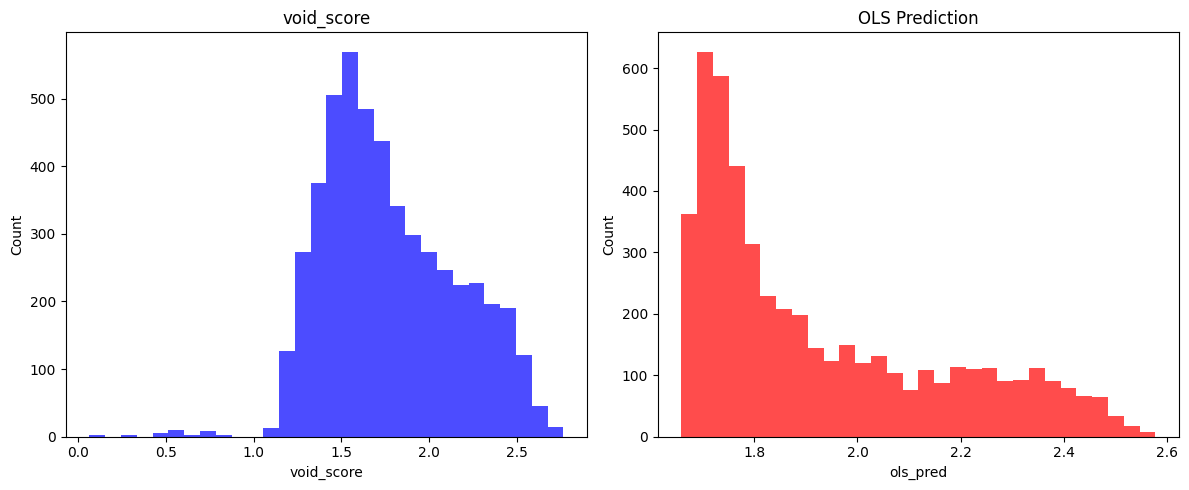

In [37]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.hist(df['void_score'], bins=30, color='blue', alpha=0.7)
plt.title('void_score')
plt.xlabel('void_score')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(df['ols_pred'], bins=30, color='red', alpha=0.7)
plt.title('OLS Prediction')
plt.xlabel('ols_pred')
plt.ylabel('Count')

plt.tight_layout()
plt.show()



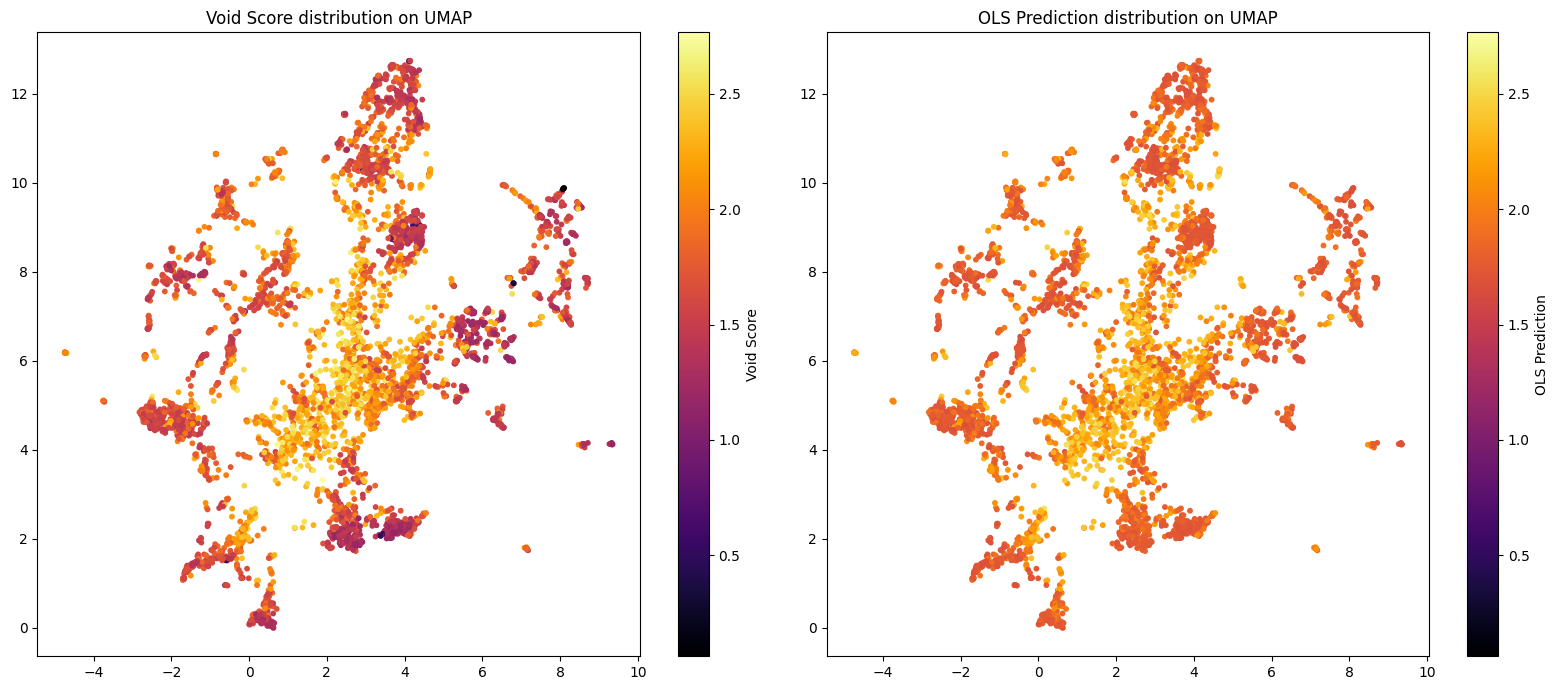

In [38]:
plt.figure(figsize=(16, 7))

vmin = min(df['void_score'].min(), df['ols_pred'].min())
vmax = max(df['void_score'].max(), df['ols_pred'].max())

plt.subplot(1, 2, 1)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['void_score'], cmap='inferno', s=10, vmin=vmin, vmax=vmax)
plt.colorbar(label='Void Score')
plt.title("Void Score distribution on UMAP")

plt.subplot(1, 2, 2)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['ols_pred'], cmap='inferno', s=10, vmin=vmin, vmax=vmax)
plt.colorbar(label='OLS Prediction')
plt.title("OLS Prediction distribution on UMAP")

plt.tight_layout()
plt.show()

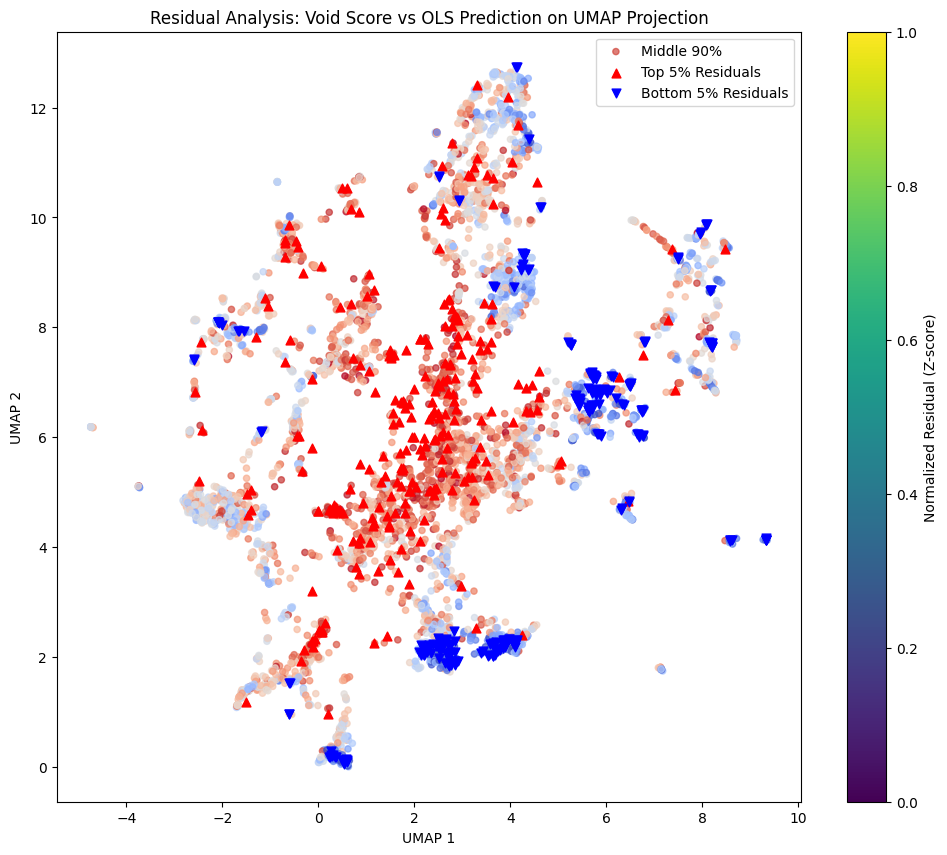

In [46]:
df['residual'] = df['void_score'] - df['ols_pred']
df['residual_norm'] = (df['residual'] - df['residual'].mean()) / df['residual'].std()

high_thresh = df['residual_norm'].quantile(0.95)
low_thresh  = df['residual_norm'].quantile(0.05)

high_resid = df['residual_norm'] >= high_thresh
low_resid  = df['residual_norm'] <= low_thresh
mid_resid  = ~(high_resid | low_resid)


plt.figure(figsize=(12, 10))


plt.scatter(X_umap[mid_resid, 0], X_umap[mid_resid, 1],
            c=df['residual_norm'][mid_resid], cmap='coolwarm', s=20, alpha=0.7, label='Middle 90%')


plt.scatter(X_umap[high_resid, 0], X_umap[high_resid, 1],
            c='red', s=40, marker='^', label='Top 5% Residuals')


plt.scatter(X_umap[low_resid, 0], X_umap[low_resid, 1],
            c='blue', s=40, marker='v', label='Bottom 5% Residuals')

plt.colorbar(label='Normalized Residual (Z-score)')
plt.title('Residual Analysis: Void Score vs OLS Prediction on UMAP Projection')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()


# Mapping the Comfort Zone of EfficientNet

Our main goal from the start was simple: push the model’s comfort zone D′′ D ′′ as close as possible to the real-world manifold E E. We couldn’t rely on classical validation metrics alone, because our dataset is limited and collecting more data wasn’t an option. A 1k validation set wouldn’t give statistically meaningful insights.

So, we started by examining the latent space directly—all CNN feature vectors projected into 2D with UMAP. Some class boundaries were clear, others overlapped; some overlaps were meaningful, others not. Instead of chasing every overlap, we defined a Void Score—a composite metric capturing uncertainty, sparsity, and outlierness.

The idea: trust this score to guide systematic data augmentation via diffusion or GAN models, focusing on regions where the model is most unsure or underrepresented. A simple negative trend (y = -1.5x + c) was already visible in the score, which made us ask: if this simple linear trend captures this much structure, do we really need the full complex Void Score?

What we found:

Red triangles (▲): Areas where the Void Score exceeds OLS predictions—chaotic, sparse regions in the manifold. These are real voids that OLS misses.

Blue triangles (▼): Areas where the Void Score is lower than OLS—dense, “safe” regions. Here, OLS overestimates risk.

Residual analysis metrics:

MAE: 0.0889

MAPE: 0.0419

RMSE: 0.1127

Data perspective: OLS falsely flagged 839 examples not highlighted by Void Score; conversely, only 85 risky examples (≈1.7% of the dataset) were missed by OLS but captured by the Void Score.

In short, the Void Score understands the manifold geometry: it reliably detects real risk areas (red) and ultra-safe regions (blue), outperforming a simple linear proxy. This score now serves as the information source for scenario-based synthetic augmentation, whether via GANs or OpenUSD/Blender pipelines.


In [57]:
df.to_csv("/content/drive/MyDrive/df_final.csv", index=False)
